# Red neuronal para predecir poses

## Importar librerias

In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt

from keras import layers,callbacks
from keras.models import Sequential, load_model
from keras.optimizers import Adam

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

2025-07-13 15:14:44.257094: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-13 15:14:44.266167: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752441284.276455    7596 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752441284.279797    7596 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752441284.287888    7596 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Preparar datos

In [2]:
Carpeta="Dataset"
Salida="posiciones.csv"
#
# Unir los csvs para hacer uno solo
csvs=[os.path.join(Carpeta,f) for f in os.listdir(Carpeta) if f!=Salida]
#print(csvs)
df=pd.concat((pd.read_csv(f) for f in csvs),ignore_index=True)
df.to_csv(os.path.join(Carpeta,Salida), index=False, float_format="%.6f")

#print(df)

X= df.drop(columns=['label'])
Y= df['label']

poses_lb=LabelBinarizer()
Y_one_hot= poses_lb.fit_transform(Y)
#print(Y_one_hot)

## Dividir datos en:
* Entrenamiento = 70%
* Validación = 15%
* Prueba = 15%

In [3]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, Y_one_hot, test_size=0.30, stratify=Y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp.argmax(1), random_state=42)

## Definicion y compilacion de Red Neuronal

In [4]:
n_features = X_train.shape[1]   # 36 o 99
n_classes  = y_train.shape[1]
#print(n_features,n_classes)
#
model = Sequential([
    layers.Input( shape=(n_features,)),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.30),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.30),
    layers.Dense(n_classes, activation='softmax')
])
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

I0000 00:00:1752441286.484673    7596 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4968 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


## Entrenamiento

In [5]:
checkpoint = callbacks.ModelCheckpoint(
    "best_model.keras", save_best_only=True, monitor='val_loss')

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=256,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint],
    verbose=2)


Epoch 1/50


I0000 00:00:1752441287.853925    7755 service.cc:152] XLA service 0x7096c8002d20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752441287.853943    7755 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-07-13 15:14:47.881152: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1752441288.029875    7755 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1752441290.031781    7755 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


22/22 - 5s - 244ms/step - accuracy: 0.6980 - loss: 0.8049 - val_accuracy: 0.6465 - val_loss: 1.1484
Epoch 2/50
22/22 - 0s - 9ms/step - accuracy: 0.9190 - loss: 0.2594 - val_accuracy: 0.6934 - val_loss: 1.0001
Epoch 3/50
22/22 - 0s - 9ms/step - accuracy: 0.9619 - loss: 0.1426 - val_accuracy: 0.8066 - val_loss: 0.8891
Epoch 4/50
22/22 - 0s - 9ms/step - accuracy: 0.9741 - loss: 0.0965 - val_accuracy: 0.7905 - val_loss: 0.7927
Epoch 5/50
22/22 - 0s - 8ms/step - accuracy: 0.9825 - loss: 0.0698 - val_accuracy: 0.5750 - val_loss: 0.8033
Epoch 6/50
22/22 - 0s - 9ms/step - accuracy: 0.9872 - loss: 0.0558 - val_accuracy: 0.5911 - val_loss: 0.7372
Epoch 7/50
22/22 - 0s - 9ms/step - accuracy: 0.9898 - loss: 0.0470 - val_accuracy: 0.6533 - val_loss: 0.6617
Epoch 8/50
22/22 - 0s - 9ms/step - accuracy: 0.9934 - loss: 0.0358 - val_accuracy: 0.6925 - val_loss: 0.5963
Epoch 9/50
22/22 - 0s - 9ms/step - accuracy: 0.9932 - loss: 0.0286 - val_accuracy: 0.7036 - val_loss: 0.5627
Epoch 10/50
22/22 - 0s - 8ms

## Evaluación

In [6]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Accuracy en test: {test_acc:.3f}")


y_pred = model.predict(X_test)
cm = confusion_matrix(y_test.argmax(1), y_pred.argmax(1))
print(cm)
print(classification_report(y_test.argmax(1), y_pred.argmax(1), target_names=poses_lb.classes_))

#Distancia cosenoidal entre los datos (Por cada clase)
#Tomar 10 frames de cada segundo

Accuracy en test: 0.998
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
[[292   0   0   0]
 [  0 300   0   0]
 [  0   2 437   0]
 [  0   0   0 144]]
                 precision    recall  f1-score   support

Brazos cruzados       1.00      1.00      1.00       292
         Firmes       0.99      1.00      1.00       300
           Otra       1.00      1.00      1.00       439
 Posicion fetal       1.00      1.00      1.00       144

       accuracy                           1.00      1175
      macro avg       1.00      1.00      1.00      1175
   weighted avg       1.00      1.00      1.00      1175



## Graficas de resultados

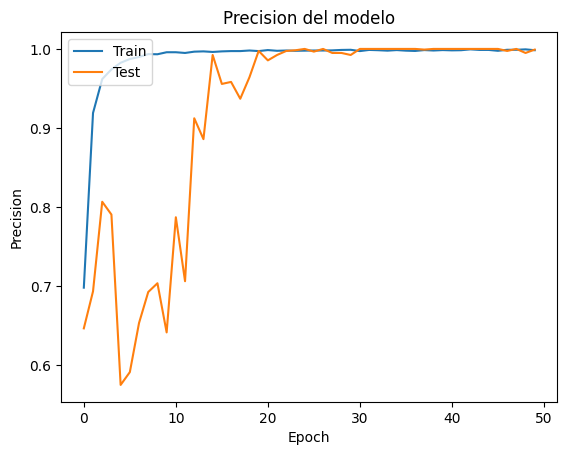

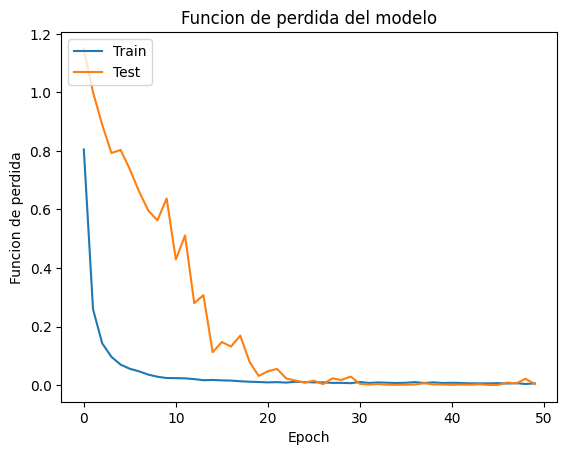

In [7]:
#Evaluar resultados
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precision del modelo')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#Funcion de perdida
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Funcion de perdida del modelo')
plt.ylabel('Funcion de perdida')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Uso del modelo para predicción

In [10]:
import imageLandmarks

imagen=imageLandmarks.IMAGEN("Fotos/image.png")
imagen.process(True)
x_new=imagen.extrae_frames()
x_new=np.array([x_new])
print(len(x_new))

prediccion  = model.predict(x_new)
print (prediccion)
label  = poses_lb.inverse_transform(prediccion)
print(label)


I0000 00:00:1752441384.240331    7596 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1752441384.268619   15482 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.144.03), renderer: NVIDIA GeForce RTX 4060 Laptop GPU/PCIe/SSE2
W0000 00:00:1752441384.316068   15457 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1752441384.404346   15477 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


[0.5151408314704895, 0.12388980388641357, -0.410516619682312, 0.5371013283729553, 0.1047186627984047, -0.3877306282520294, 0.5505034923553467, 0.10574290156364441, -0.38851264119148254, 0.5636589527130127, 0.10710403323173523, -0.3885844349861145, 0.49591076374053955, 0.1035374104976654, -0.38556450605392456, 0.4818163514137268, 0.10378342866897583, -0.38649782538414, 0.4687800407409668, 0.10462590306997299, -0.38691848516464233, 0.585877537727356, 0.1164318323135376, -0.22288668155670166, 0.45612475275993347, 0.11411122232675552, -0.21174876391887665, 0.5416460633277893, 0.14955028891563416, -0.34008732438087463, 0.489414781332016, 0.14697346091270447, -0.34194865822792053, 0.6683605909347534, 0.24311676621437073, -0.17290817201137543, 0.36942413449287415, 0.23792731761932373, -0.07363874465227127, 0.719523012638092, 0.40645524859428406, -0.11123038083314896, 0.31252771615982056, 0.3818463087081909, -0.09619522839784622, 0.7392994165420532, 0.5513121485710144, -0.16479921340942383, 0.